# NNIA 18/19 Project 3:  Regularization and Data Augmentation

## 1. Dropout$~$ (9 points)

In the following exercise you would use an already implemented **feed-forward network** using **only** Numpy. We will add here the dropout regualrization technique that you learned about in the lecture.

The goal is to implement dropout for layer 2 in the provided three-layers network.

Before you start, here is a simple introduction about dropout. Dropout is a regualization technique that performs random dropping of neurons with a certain probability at each mini-batch in training time. Introducing such randomness or noise at training is helpful to make the network not fully dependent on the training set and therefore, it could generalize better to other unseen data. 

A simple dropout implementation creates a mask ($r^{(l)}_j$) for every neuron $j$ of the hidden layer $l$ by drawing from a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) with probability $p$, where $p$ is the probability of keeping neurons. You can think of it as a coin flip for each neuron with a probability $p$ to determine if that neuron will be kept or not. For more information, refer to section 7.12 in Deep Learning book.

$$ r^{(l)}_j \sim Bernoulli(p) $$
This mask is then applied to the hidden layer output ($h^{(l)}$) to obtain the regularized hidden layer activation $\hat{h}^{(l)}$
$$ \hat{h}^{(l)} = r^{(l)} * h^{(l)}$$
However, such an implementation requires the layer to be multiplied by the dropout coefficient $p$ at evaluation time to balance the larger number of active units during testing.
$$ \hat{h}^{(l)} = p * h^{(l)}$$
Such an implementation requires the code to switch between different code blocks for forward-pass evaluation during training and testing. Hence, a smoother way to implement dropout is to use ***inverted dropout*** where the mask generated at the training is multiplied by the inverse of the dropout coefficient.
$$ r^{(l)}_j \sim Bernoulli(p) * \frac{1}{p}$$
This scheme allows the scaling to be learned during training and hence, no switching between code blocks is required. The idea of using inverted dropout is to provide a form of normalization; when dropping out neurons during training, we are now giving the network less neurons that what it will have in the test time. So, dividing by the keep_probs is done to scale the training so that we will not need to do anything in test time. 

a) The following code implements a simple one-hiddien-layer neural network similar to what you have done in project 2. Update this code to implement inverted dropout for a hidden layer size of 50 neurons (sections to be updated are marked with TODO). Make sure to handle forward and backward passes and handle inference time as well (5.5 points)


In [0]:
import os
import struct
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

fashion_mnist = tf.keras.datasets.fashion_mnist
(X_trainval, Y_trainval), (X_test, Y_test) = fashion_mnist.load_data()

In [0]:
print(X_trainval.shape)

(60000, 28, 28)


In [0]:
X_trainval = np.reshape(X_trainval, (X_trainval.shape[0],  X_trainval.shape[1] *  X_trainval.shape[2]))
print('The X_trainval has the following shape:')
print('Rows: %d, columns: %d' % (X_trainval.shape[0], X_trainval.shape[1]))

The X_trainval has the following shape:
Rows: 60000, columns: 784


In [0]:
X_test = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1] *  X_test.shape[2]))
print('The X_test has the following shape:')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

The X_test has the following shape:
Rows: 10000, columns: 784


- Normalize the data. Subtract the mean and divide by the standard deviation.

In [0]:
def data_normalization(X_trainval, X_test):
    feature_means = X_trainval.mean(axis = 0)
    feature_std = np.std(X_trainval, axis = 0)
    X_trainval_normalized = (X_trainval - feature_means) / feature_std
    X_test_normalized = (X_test - feature_means) / feature_std
    return X_trainval_normalized, X_test_normalized

In [0]:
# The normalization should be done on X_train and X_test
# and normalized data should have the exactly same shape as the original data matrix.

X_trainval, X_test = data_normalization(X_trainval, X_test)
print(X_trainval.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [0]:
from __future__ import division
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit



class MLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_output : int
        Number of output units, should be equal to the
        number of unique class labels.
        
    n_features : int
        Number of features (dimensions) in the target dataset.
        Should be equal to the number of columns in the X array.
        
    n_hidden : int (default: 30)
        Number of hidden units.
        
    l1 : float (default: 0.0)
        Lambda value for L1-regularization.
        No regularization if l1=0.0 (default)
        
    l2 : float (default: 0.0)
        Lambda value for L2-regularization.
        No regularization if l2=0.0 (default)
        
    epochs : int (default: 500)
        Number of passes over the training set.
        
    eta : float (default: 0.001)
        Learning rate.
        
    alpha : float (default: 0.0)
        Momentum constant.
        
    decrease_const : float (default: 0.0)
        Decrease constant. Shrinks the learning rate
        after each epoch via eta / (1 + epoch*decrease_const)
        
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
        
    minibatches : int (default: 1)
        Divides training data into k minibatches for efficiency.
        Normal gradient descent learning if k=1 (default).
        
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.
    
    dropout : float (default: 1.0, no dropout)
        Set the dropout coefficient (keep probability of neurons)

    Attributes
    -----------
    cost_ : list
      Sum of squared errors after each epoch.

    """

      
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=50, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=1, dropout = 1.0):

        self.n_output = n_output
        self.r = np.random.RandomState(random_state)
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
        # The dropout variable is the keep probability for neurons.
        # Initialize the class variable "dropout" like other variables above. Also, initialize a variable mask to None.
        # This will allow sharing dropout information during forward and backward pass of the neural networks. Note 
        # that the __init__ function has already been modified to include dropout coefficient as an argument. (0.5 points)
        
        #TODO: Implement
        self.dropout = dropout
        self.mask = None

    def _encode_labels(self, y, k):    
        """Encode the labels using one-hot representation

        Parameters
        ------------
        y : y represents target values.

        Returns
        -----------
        onehot array

        """
       
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        
        w1 = self.r.uniform(-1.0, 1.0, size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = self.r.uniform(-1.0, 1.0, size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        
        return w1, w2

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)

        Uses scipy.special.expit to avoid overflow
        error for very small input values z.

        """
        
        return expit(z)

    def _sigmoid_gradient(self, z):
        """Compute gradient of the logistic function"""
        
        sg = self._sigmoid(z)
        return sg * (1.0 - sg)

    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        
        return X_new

    def _feedforward(self, X, w1, w2, if_train=True):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.
        if_train: if this is during training

        Returns
        ----------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        z3 : array, shape = [n_output_units, n_samples]
            Net input of output layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.

        """
        
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        
        # Implement inverted dropout using the class variables dropout and activation variable (a2) for the forward
        # pass for the second hidden layer below. To create the mask you will have to use self.r.binomial for 
        # generating the bernoulli distribution. The mask created here needs to be stored in the appropriate mask
        # variable defined in the __init__ function for further use by the backward pass.
        # Make sure to handle the inference case (2.5 points)
        
        # TODO: Implement
        self.mask = self.r.binomial(1,self.dropout, size = self.n_hidden+1)
        a2 = a2 * self.mask[:,np.newaxis] * (1 / self.dropout)
        
        
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        """Compute L2-regularization cost"""
        
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) +
                                np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        """Compute L1-regularization cost"""
        
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() +
                                np.abs(w2[:, 1:]).sum())

    def _get_cost(self, y_enc, output, w1, w2):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        output : array, shape = [n_output_units, n_samples]
            Activation of the output layer (feedforward)
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        cost : float
            Regularized cost.

        """
        np.seterr(divide='ignore')
        term1 = -y_enc * (np.log(output))
        term2 = (1.0 - y_enc) * np.log(1.0 - output)
        
        term1[np.isneginf(term1)] = 0
        term2[np.isneginf(term2)] = 0
        
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        """ Compute gradient step using backpropagation.

        Parameters
        ------------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        grad1 : array, shape = [n_hidden_units, n_features]
            Gradient of the weight matrix w1.
        grad2 : array, shape = [n_output_units, n_hidden_units]
            Gradient of the weight matrix w2.
        """
        
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        
        # Implement dropout for the backward pass, use class variables for mask and dropout for this task (2.5 points)
        
        # TODO: Implement
        sigma2 = sigma2 * self.mask[:,np.newaxis] * (1 / self.dropout)
        
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += self.l2 * w1[:, 1:]
        grad1[:, 1:] += self.l1 * np.sign(w1[:, 1:])
        grad2[:, 1:] += self.l2 * w2[:, 1:]
        grad2[:, 1:] += self.l1 * np.sign(w2[:, 1:])

        return grad1, grad2

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                 'Use X[:,None] for 1-feature classification,'
                                 '\nor X[[i]] for 1-sample classification')

        #TODO: Call the feedforward to get a1, z2, a2, z3, a3 (0.5 point)
        self.dropout = 1
        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
    
        y_pred = np.argmax(z3, axis=0)
        
        return y_pred

    def fit(self, X, y, print_progress=False, validation_freq=0, X_val=None, y_val=None, data_augmentation=False):
        """ Learn weights from training data.

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        y : array, shape = [n_samples]
            Target class labels.
        print_progress : bool (default: False)
            Prints progress as the number of epochs
            to stderr.
        validation_freq=0, X_val=None, y_val=None: If provided, perform validation check for early stopping (Task 2)
        data_augmentation: bool (default: False)
            If true, perform data augmentation (Task 3)

        Returns:
        ----------
        self

        """
        
        self.cost_ = []
        train_err = []
        test_err = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):
            
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                print('\nEpoch: %d/%d' % (i+1, self.epochs))
            
            if X_val is not None and y_val is not None:
                if i % validation_freq == 0:
                    train_predict = self.predict(X)
                    train_error = 0
                    for i, val in np.ndenumerate(train_predict):
                        if train_predict[i] != y[i]:
                            train_error += 1
                    train_error /= y.shape[0]
                    train_error *= 100
                    train_err.append(train_error)

                    val_predict = self.predict(X_val)
                    val_error = 0
                    for i, val in np.ndenumerate(val_predict):
                        if val_predict[i] != y_val[i]:
                            val_error += 1
                    val_error /= y_val.shape[0]
                    val_error *= 100
                    test_err.append(val_error)
    
                
            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:
                if (data_augmentation==True):
                    #print('online data augmentation included!')
                    X_mini = online_augmentation(X_data[idx].reshape(idx.shape[0], 28,28))
                    X_mini = X_mini.reshape(idx.shape[0], 28*28)
                else:
                    #print('No augmentation')
                    X_mini = X_data[idx]
                
                #print("X_mini.shape", X_mini.shape)
                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_mini,
                                                       self.w1,
                                                       self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self, train_err, test_err


In [0]:
#TODO: for each dropout value, create a class instance and call the fit function and print the training and test accuracy in percentage for each value of dropout.
vals = np.arange(0.3, 1.0, 0.3)
train_acc_list = []
test_acc_list = []
for dropout in vals:
    # create a MLP object
    print('Dropout: %.2f' % dropout)
    nn = MLP(n_output=10, 
             n_features=X_trainval.shape[1], 
             n_hidden=50, 
             l2=0.0, 
             l1=0.0, 
             epochs=500,
             eta=0.001,
             alpha=0.001,
             decrease_const=0.00001,
             minibatches=50, 
             shuffle=False,
             random_state=1,
             dropout = dropout)
    
    # Fit the data with NN
    nn.fit(X_trainval, Y_trainval, print_progress=False)
    
    # Print the training accuracy and test accuracy in percentage for each value of dropout. This part is same as 
    # a question asked in Exercise 2, so you may use the code from there. (0 points) 
    pred_labels_training = nn.predict(X_trainval)
    train_acc = 0
    #print (pred_labels_training)
    #print (y_train)
    for index,val in np.ndenumerate(pred_labels_training):
        if pred_labels_training[index] == Y_trainval[index]:
            train_acc += 1
    train_acc /= Y_trainval.shape[0]
    train_acc_list.append(train_acc*100)
    print('Training accuracy: %.2f%%' % (train_acc * 100))
    
    pred_labels_test = nn.predict(X_test)
    test_acc = 0
    #print (pred_labels_test)
    #print (y_test)
    for index,val in np.ndenumerate(pred_labels_test):
        if pred_labels_test[index] == Y_test[index]:
            test_acc += 1
    test_acc /= Y_test.shape[0]
    test_acc_list.append(test_acc*100)
    print('Test accuracy: %.2f%%' % (test_acc * 100))
    

#Initialize the class for each dropout value as follows:
# """
# nn = MLP(n_output=10, 
#              n_features=X_trainval.shape[1], 
#              n_hidden=50, 
#              l2=0.0, 
#              l1=0.0, 
#              epochs=500, 
#              eta=0.001,
#              alpha=0.001,
#              decrease_const=0.00001,
#              minibatches=50, 
#              shuffle=False,
#              random_state=1,
#              dropout = dropout)
# """ 

Dropout: 0.30
Training accuracy: 87.86%
Test accuracy: 84.62%
Dropout: 0.60
Training accuracy: 89.89%
Test accuracy: 85.53%
Dropout: 0.90
Training accuracy: 92.42%
Test accuracy: 85.67%


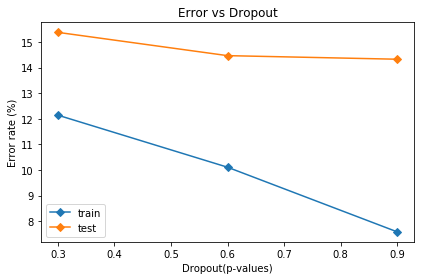

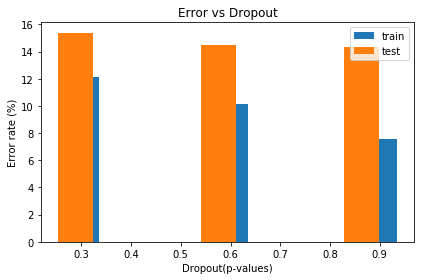

In [0]:
import matplotlib.pyplot as plt

# Plot the training error and validation error for p values
# TODO: Implement
p1 = plt.plot(vals,np.subtract([100], train_acc_list), marker='D', label='train')
p2 = plt.plot(vals,np.subtract([100], test_acc_list), marker='D', label='test')
plt.xlabel('Dropout(p-values)')
plt.ylabel('Error rate (%)')
plt.legend()
plt.title('Error vs Dropout')
plt.tight_layout()
plt.show()

p1 = plt.bar(vals, np.subtract([100], train_acc_list), width=0.07, label='train')
p2 = plt.bar(vals*0.96, np.subtract([100], test_acc_list), width=0.07, label='test') 
# Note: X-axis in p2 is multiplied by 0.96 just to avoid the overlap
plt.xlabel('Dropout(p-values)')
plt.ylabel('Error rate (%)')
plt.legend()
plt.title('Error vs Dropout')
plt.tight_layout()
plt.show()

## 2. Early Stopping$~$ (9 points)

For reference see Wikipedia page: https://en.wikipedia.org/wiki/Early_stopping, and also refer to section 7.8 in Deep Learning book.

*Early stopping* is a form of regualrization that avoids overfitting by using the validation set error as an indication on when to stop the training before the validation set error starts increasing again. 

Goal: To study how increasing neurons of a neural network (model complexity) affects the Early Stopping threshold.

In [0]:
#TODO: create two classes instances and fit two times with different neurons number

#TODO: Plots for training and test errors for the 2 models

neurons = [50, 200]
train_err_lst = []
test_err_lst = []
    
for n, hidden in enumerate(neurons):
    print("Number of hidden units:",hidden)
    nn = MLP(n_output=10, 
             n_features=X_trainval.shape[1], 
             n_hidden=hidden, 
             l2=0.0, 
             l1=0.0, 
             epochs=800, 
             eta=0.001,
             alpha=0.001,
             decrease_const=0.00001,
             minibatches=50, 
             shuffle=False,
             random_state=1)
    
    _, train_err, test_err = nn.fit(X_trainval, Y_trainval, print_progress=False,
             validation_freq=100,
             X_val=X_test, y_val=Y_test)
    
     #print("Val errs:",test_err)
    #print("train errs:", train_err)
    train_err_lst.append(train_err)
    test_err_lst.append(test_err)
    iter = [ (i+1)*100 for i in range(800 // 100)]
    plt.subplot(1,len(neurons),n+1)
    plt.plot(iter, train_err, label='Training Error')
    plt.plot(iter, test_err, label='Validation Error')
    #plt.yscale('log')
    #plt.ylim([0, 100])
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    plt.legend(loc='upper right')
    plt.title("Neurons: {0} (error)".format(hidden))
    plt.tight_layout()
    plt.show()

    

Number of hidden units: 50
Val errs: [92.80000000000001, 14.81, 15.18, 15.07, 15.129999999999999, 15.260000000000002, 15.190000000000001, 15.229999999999999]
train errs: [92.995, 9.633333333333335, 7.548333333333333, 6.306666666666666, 5.533333333333333, 5.088333333333334, 4.843333333333334, 4.706666666666667]


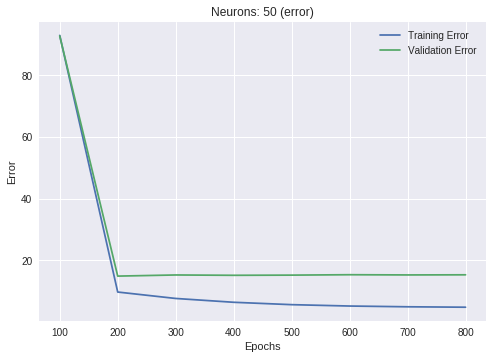

Number of hidden units: 200
Val errs: [84.38, 14.56, 14.95, 14.97, 14.96, 14.879999999999999, 14.790000000000001, 14.729999999999999]
train errs: [84.355, 4.8, 1.3416666666666668, 0.4066666666666666, 0.18666666666666668, 0.11499999999999999, 0.08666666666666667, 0.07666666666666667]


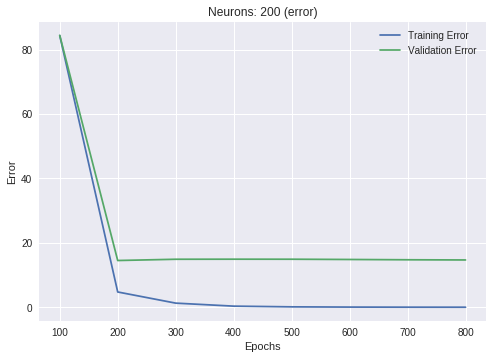

In [0]:
#TODO: create two classes instances and fit two times with different neurons number

#TODO: Plots for training and test errors for the 2 models

neurons = [50, 200]
train_err_lst = []
test_err_lst = []
#plt.figure(figsize=(10,3))
for n, hidden in enumerate(neurons):
    #create a MLP object
    print("Number of hidden units:",hidden)
    nn = MLP(n_output=10, 
             n_features=X_trainval.shape[1], 
             n_hidden=hidden, 
             l2=0.0, 
             l1=0.0, 
             epochs=800, 
             eta=0.001,
             alpha=0.001,
             decrease_const=0.00001,
             minibatches=50, 
             shuffle=False,
             random_state=1)
    
    # Fit the data with NN
    _, train_err, test_err = nn.fit(X_trainval, Y_trainval, print_progress=False,
             validation_freq=100,
             X_val=X_test, y_val=Y_test)
    
    #print("Val errs:",test_err)
    #print("train errs:", train_err)
    train_err_lst.append(train_err)
    test_err_lst.append(test_err)
    iter = [ (i+1)*100 for i in range(800 // 100)]
    plt.plot(iter, train_err, label='Training Error')
    plt.plot(iter, test_err, label='Validation Error')
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    plt.legend(loc='upper right')
    plt.title("Neurons: {0} (error)".format(hidden))
    plt.show()

## 3. Data Augmentation$~$ (12 points)

While the performance of neural networks can significantly increase with increasing training data size, collecting a large dataset is hard and needs a lot of work in annotation. Therefore, data augmentation is a widley used technique in machine learning to artificially increase your training set size. In case of images, data augmentation methods can be scaling, rotations, cropping, or mirroring. In this exercise, we will get familiar with some of these techniques and apply them on the MNIST fashion dataset. 

For additional reading, you can refer to the following paper (also known as AlexNet) which is one of the papers that revolutionized neural networks applications in image classification and has used data augmentation to increase training data size:

Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." Advances in neural information processing systems. 2012 (http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf).

**Additional note:** These types of augmentation methods usually work best with a type of neural networks called *Convolutional Neural Networks (CNNs)* becuase these networks can learn features that are invariant under transformations (Wikipedia: https://en.wikipedia.org/wiki/Convolutional_neural_network). However, we will use it here with a simple fully connected network to learn the concept. 


In [0]:
# select imput image for each transformations
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_trainval, Y_trainval), (X_test, Y_test) = fashion_mnist.load_data()
input_img = X_trainval[np.random.randint(X_trainval.shape[0], size=1)].reshape(28, 28)

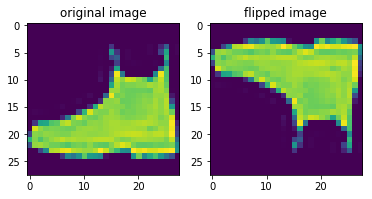

In [0]:
#TODO: Implement vertical flipping. Use Numpy
def flip_img(one_input_image):
    flipped_image = np.flip(m=one_input_image, axis=0)
    #flipped_image = input_img[::-1, :]
    #flipped_image = np.flipud(input_img)
    return flipped_image

flipped_img = flip_img(input_img)
# Plot
import matplotlib.pyplot as plt
plt.axis('off')
plt.subplot(1,2,1, title='original image')
plt.imshow(input_img)
plt.subplot(1,2,2, title='flipped image')
plt.imshow(flipped_img)
plt.show()

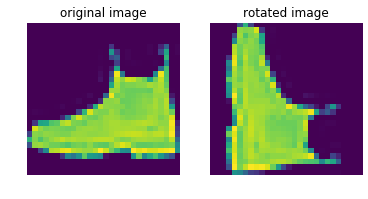

In [0]:
#TODO: Implement image rotation by 90 degrees clockwise using Numpy
def rotate_img(one_input_image):
    rotated_img = np.rot90(m=one_input_image, k=1, axes=(1,0))
    return rotated_img

rotated_img = rotate_img(input_img)
# plot
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1, title='original image')
plt.imshow(input_img)
plt.axis('off')
plt.subplot(1, 2, 2, title='rotated image')
plt.imshow(rotated_img)
plt.axis('off')
plt.show()

(28, 28)


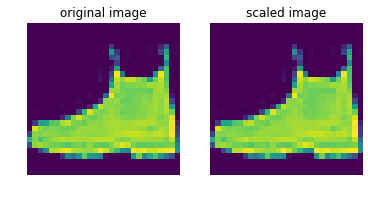

In [0]:
#TODO: Implement image scaling
#For this, you can use an image processing library such as: https://scikit-image.org/ (install if needed)

def scale_img(one_input_image, scale_ratio):
    import skimage
    scaled_img = skimage.transform.rescale(image=one_input_image, scale=scale_ratio)
    crop_width = (scaled_img.shape[0]-28)//2
    crop_img = skimage.util.crop(ar=scaled_img, crop_width=crop_width)
    #print(crop_img.shape)
    return crop_img

scaled_image = scale_img(input_img, scale_ratio=1.0)
print(scaled_image.shape)
# plot
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1, title='original image')
plt.imshow(input_img)
plt.axis('off')
plt.subplot(1, 2, 2, title='scaled image')
plt.imshow(scaled_image)
plt.axis('off')
plt.show()

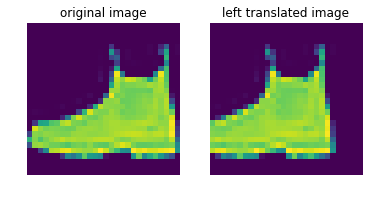

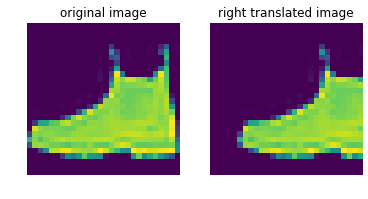

In [0]:
#TODO: Implement image translation. Use Numpy
def translate_img(one_input_image, right_or_left_flag, shift_pixels):
    tr_img = np.zeros((one_input_image.shape[0],one_input_image.shape[1]))
    for row_idx in range(one_input_image.shape[0]):
        for col_idx in range(one_input_image.shape[1]):
            if(right_or_left_flag=='right'):
                tot_shift = col_idx+shift_pixels
            elif(right_or_left_flag=='left'):
                tot_shift = col_idx-shift_pixels
            else:
                print("specify 'left' or 'right' shift")
            if(tot_shift<0 or tot_shift>=one_input_image.shape[1]):
                pass
            else:
                tr_img[row_idx, tot_shift] =  input_img[row_idx, col_idx]
    return tr_img

left_tr_img = translate_img(input_img, 'left', 5)
plt.subplot(1, 2, 1, title='original image')
plt.imshow(input_img)
plt.axis('off')
plt.subplot(1, 2, 2, title='left translated image')
plt.imshow(left_tr_img)
plt.axis('off')
plt.show()
right_tr_img = translate_img(input_img, 'right', 5)
plt.subplot(1, 2, 1, title='original image')
plt.imshow(input_img)
plt.axis('off')
plt.subplot(1, 2, 2, title='right translated image')
plt.imshow(right_tr_img)
plt.axis('off')
plt.show()

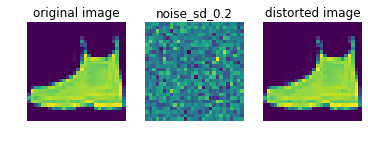

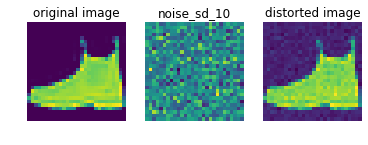

In [0]:
#TODO: Implement adding Gaussian noise. Use Numpy
def distort_img(one_input_image, sd=0.2):
    noise = np.random.normal(0, sd, one_input_image.shape)
    distorted_img = one_input_image + noise
    return distorted_img, noise

def distort_img_(one_input_image, sd=0.2):
    noise = np.random.normal(0, sd, one_input_image.shape)
    distorted_img = one_input_image + noise
    return distorted_img

dist_image, noise = distort_img(input_img)
plt.subplot(1, 3, 1, title='original image')
plt.imshow(input_img)
plt.axis('off')
plt.subplot(1, 3, 2, title='noise_sd_0.2')
plt.imshow(noise)
plt.axis('off')
plt.subplot(1, 3, 3, title='distorted image')
plt.imshow(dist_image)
plt.axis('off')
plt.show()

dist_image, noise = distort_img(input_img, 10.0)
plt.subplot(1, 3, 1, title='original image')
plt.imshow(input_img)
plt.axis('off')
plt.subplot(1, 3, 2, title='noise_sd_10')
plt.imshow(noise)
plt.axis('off')
plt.subplot(1, 3, 3, title='distorted image')
plt.imshow(dist_image)
plt.axis('off')
plt.show()

In [0]:
#TODO: Implement online_augmentation
def online_augmentation(batch_images):
    #print('Online augmentation included')
    batch_images = batch_images.reshape(batch_images.shape[0], 28, 28)
    augmented_batch = []
    for idx, img in enumerate(batch_images):
        if(np.random.uniform(0.0, 1.0, 1)>0.5):
            #print('augmenting image %d' %idx)
            import random
            aug_selector = random.choice(
                ['flip', 'scale', 'rotate', 'translate', 'GaussianDistortion'])
            if aug_selector=='flip':
                #print('flipping')
                augmented_batch.append(flip_img(img))
            elif aug_selector=='scale':
                #print('scaling')
                augmented_batch.append(scale_img(img, np.random.randint(1,3,1)))
            elif aug_selector=='rotate':
                #print('rotating')
                augmented_batch.append(rotate_img(img)) 
            elif aug_selector=='translate':
                #print('tranlsating')
                shift_dir = random.choice(['right', 'left'])
                augmented_batch.append(translate_img(img, shift_dir, np.random.randint(5,10,1)))
            elif aug_selector=='GaussianDistortion':
                #print('distorting')
                augmented_batch.append(distort_img_(img))
        else:
            #print('image %d is not augmented' %idx)
            augmented_batch.append(img)
    return np.asarray(augmented_batch)

batch_images=X_trainval[0:50]
aug_batch = online_augmentation(batch_images)
# plt.imshow(aug_batch[np.random.randint(1,50,1)[0]])
# np.random.randint(1,50,1)[0]
# for i in range(len(aug_batch)):
#     print(aug_batch[i].shape)
aug_batch.shape

(50, 28, 28)

In [0]:
#TODO: create an instrance of the class
#TODO: run the fit function
#TODO: Plot the train and test performance over epochs
print(X_trainval.shape)
hidden = 50  
print("Number of hidden units:",hidden)
nn = MLP(n_output=10, 
         n_features=X_trainval.shape[1], 
         n_hidden=hidden, 
         l2=0.0, 
         l1=0.0, 
         epochs=200, 
         eta=0.001,
         alpha=0.001,
         decrease_const=0.00001,
         minibatches=50, 
         shuffle=False,
         random_state=1)

# Fit the data with NN
_, train_err, test_err = nn.fit(X_trainval, Y_trainval, print_progress=False,
         validation_freq=1, data_augmentation=True, X_val=X_test, y_val=Y_test)

pred_labels_training = nn.predict(X_trainval)
train_acc = 0
#print (pred_labels_training)
#print (y_train)
for index,val in np.ndenumerate(pred_labels_training):
    if pred_labels_training[index] == Y_trainval[index]:
        train_acc += 1
train_acc /= Y_trainval.shape[0]
#train_acc_list.append(train_acc*100)
print('Training accuracy: %.2f%%' % (train_acc * 100))

pred_labels_test = nn.predict(X_test)
test_acc = 0
#print (pred_labels_test)
#print (y_test)
for index,val in np.ndenumerate(pred_labels_test):
    if pred_labels_test[index] == Y_test[index]:
        test_acc += 1
test_acc /= Y_test.shape[0]
#test_acc_list.append(test_acc*100)
print('Test accuracy: %.2f%%' % (test_acc * 100))



(60000, 784)
Number of hidden units: 50
Training accuracy: 85.89%
Test accuracy: 82.54%


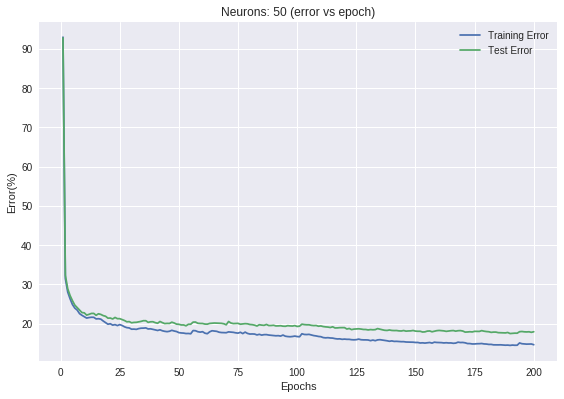

In [0]:
iter = [ (i+1)*1 for i in range(200 // 1)]
plt.plot(iter, train_err, label='Training Error')
plt.plot(iter, test_err, label='Test Error')
#plt.yscale('log')
#plt.ylim([0, 100])
plt.ylabel('Error(%)')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Neurons: {0} (error vs epoch)".format(hidden))
plt.show()

# For 400 epochs

In [0]:
#TODO: create an instrance of the class
#TODO: run the fit function
#TODO: Plot the train and test performance over epochs
print(X_trainval.shape)
hidden = 50  
print("Number of hidden units:",hidden)
nn = MLP(n_output=10, 
         n_features=X_trainval.shape[1], 
         n_hidden=hidden, 
         l2=0.0, 
         l1=0.0, 
         epochs=400, 
         eta=0.001,
         alpha=0.001,
         decrease_const=0.00001,
         minibatches=50, 
         shuffle=False,
         random_state=1)

# Fit the data with NN
_, train_err, test_err = nn.fit(X_trainval, Y_trainval, print_progress=False,
         validation_freq=1, data_augmentation=True, X_val=X_test, y_val=Y_test)

pred_labels_training = nn.predict(X_trainval)
train_acc = 0
#print (pred_labels_training)
#print (y_train)
for index,val in np.ndenumerate(pred_labels_training):
    if pred_labels_training[index] == Y_trainval[index]:
        train_acc += 1
train_acc /= Y_trainval.shape[0]
#train_acc_list.append(train_acc*100)
print('Training accuracy: %.2f%%' % (train_acc * 100))

pred_labels_test = nn.predict(X_test)
test_acc = 0
#print (pred_labels_test)
#print (y_test)
for index,val in np.ndenumerate(pred_labels_test):
    if pred_labels_test[index] == Y_test[index]:
        test_acc += 1
test_acc /= Y_test.shape[0]
#test_acc_list.append(test_acc*100)
print('Test accuracy: %.2f%%' % (test_acc * 100))



(60000, 784)
Number of hidden units: 50
Training accuracy: 87.37%
Test accuracy: 83.45%


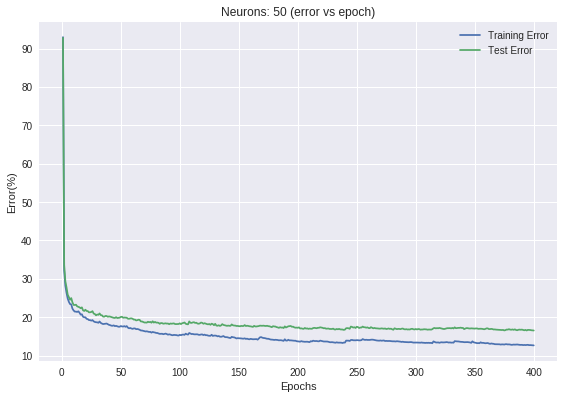

In [0]:
iter = [ (i+1)*1 for i in range(400 // 1)]
plt.plot(iter, train_err, label='Training Error')
plt.plot(iter, test_err, label='Test Error')
#plt.yscale('log')
#plt.ylim([0, 100])
plt.ylabel('Error(%)')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Neurons: {0} (error vs epoch)".format(hidden))
plt.show()

# For 1500 epochs

In [0]:
#TODO: create an instrance of the class
#TODO: run the fit function
#TODO: Plot the train and test performance over epochs
print(X_trainval.shape)
hidden = 50  
print("Number of hidden units:",hidden)
nn = MLP(n_output=10, 
         n_features=X_trainval.shape[1], 
         n_hidden=hidden, 
         l2=0.0, 
         l1=0.0, 
         epochs=1500, 
         eta=0.001,
         alpha=0.001,
         decrease_const=0.00001,
         minibatches=50, 
         shuffle=False,
         random_state=1)

# Fit the data with NN
_, train_err, test_err = nn.fit(X_trainval, Y_trainval, print_progress=False,
         validation_freq=100, data_augmentation=True, X_val=X_test, y_val=Y_test)

pred_labels_training = nn.predict(X_trainval)
train_acc = 0
#print (pred_labels_training)
#print (y_train)
for index,val in np.ndenumerate(pred_labels_training):
    if pred_labels_training[index] == Y_trainval[index]:
        train_acc += 1
train_acc /= Y_trainval.shape[0]
#train_acc_list.append(train_acc*100)
print('Training accuracy: %.2f%%' % (train_acc * 100))

pred_labels_test = nn.predict(X_test)
test_acc = 0
#print (pred_labels_test)
#print (y_test)
for index,val in np.ndenumerate(pred_labels_test):
    if pred_labels_test[index] == Y_test[index]:
        test_acc += 1
test_acc /= Y_test.shape[0]
#test_acc_list.append(test_acc*100)
print('Test accuracy: %.2f%%' % (test_acc * 100))



(60000, 784)
Number of hidden units: 50
Training accuracy: 89.36%
Test accuracy: 84.51%


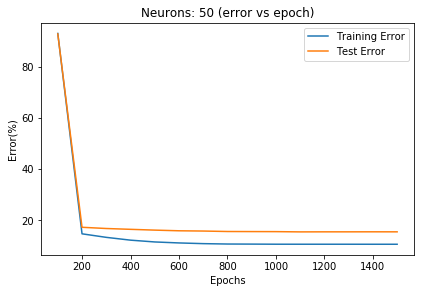

In [0]:
iter = [ (i+1)*100 for i in range(1500 // 100)]
plt.plot(iter, train_err, label='Training Error')
plt.plot(iter, test_err, label='Test Error')
#plt.yscale('log')
#plt.ylim([0, 100])
plt.ylabel('Error(%)')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.tight_layout()
plt.title("Neurons: {0} (error vs epoch)".format(hidden))
plt.show()

---